#Basic Analysis of Kubernetes

Copyright Doug Williams - 2014

###Updated: 9/23/2014

###History
- 9/23/2014:  Skeleton - Not functional

# Code

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pprint import pprint
from collections import defaultdict
import re

import sys
sys.path.append('../dev')
from jp_load_dump import jload

In [3]:
def normalize_blame_by_commit(blameset, exp_weighting=True, exp=2.0):
    """returns list of commits with weighted blame based on proximity to changes"""
    result = defaultdict(float)
    total = 0.0
    for per_file in blameset['blame'].values():
        if per_file:       #validate not null entry
            for per_line in per_file:
                found = True
                if exp_weighting:
                    weight = 1.0/(exp**(per_line['proximity']-1))
                else:
                    weight = 1.0/float(per_line['proximity'])
                result[per_line['commit']] += weight
                total += weight
    if total > 0:
        return dict([[k, v/total] for k, v in result.items()]) 
    else:
        return {}

In [4]:
re_author = re.compile('"([^"]*)"')

anon = {}
anon_ctr = 0

def get_anon_name(s):
    global anon_ctr
    parts = s.split('@')
    if len(parts) == 2:
        if parts[0] not in anon:
            anon[parts[0]] = 'anon_' + str(anon_ctr)
            anon_ctr += 1

        return anon[parts[0]] + '@' + parts[1]
    else:
        return s


def parse_author(s, anonymize=True):
    m = re_author.search(s)
    if m:
        if anonymize:
            return get_anon_name(m.groups(1)[0].encode('ascii','ignore'))
        else:
            return m.groups(1)[0].encode('ascii','ignore')
    else:
        return '**unknown**'

In [5]:
def normalize_blame_by_file(blameset, exp_weighting=True):
    """returns list of files with weighted blame"""
    result = defaultdict(float)
    total = 0.0
    for fname, per_file in blameset['blame'].items():
        if per_file:       #validate not null entry
            weight = 0.0
            for per_line in per_file:
                if exp_weighting:
                    weight +=  1.0/(2.0**(per_line['proximity']-1))
                else:
                    weight += 1.0/float(per_line['proximity'])
            result[fname] = weight
            total += weight
                
    return dict([[k, v/total] for k, v in result.items()]) 

# Load corpus

In [6]:
combined_commits = jload('Corpus/swift_combined_commits.jsonz')
print len(combined_commits)

4032


In [7]:
all_blame = jload('Corpus/swift_all_blame.jsonz')
print len(all_blame)

342


In [8]:
commits_by_author  = defaultdict(float)
for x in combined_commits.values():
    author = parse_author(x['author'])
    commits_by_author[author] += 1.0
    


In [9]:
blame_by_commit = defaultdict(float)
for x in all_blame:
    for commit, weight in normalize_blame_by_commit(x, exp_weighting=True, exp=4.0).items():
        author = parse_author(combined_commits[commit]['author'])
        blame_by_commit[author] += weight

In [10]:
#normalize by author
norm_blame_by_commit = [[k, v/ commits_by_author[k]] for k, v in blame_by_commit.items()]

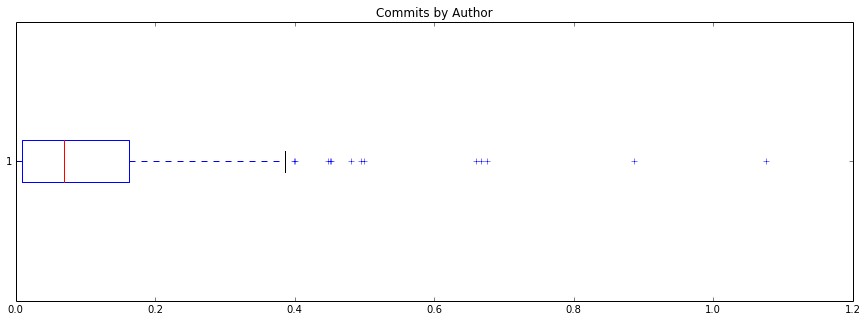

In [11]:
# basic plot
import math
plt.figure(figsize=(15, 5))
plt.title('Commits by Author')
plt.boxplot([x[1] for x in norm_blame_by_commit],vert=False)
print ''

In [12]:
# author, commits, norm, total_errore
norm_blame_vs_commit_count = [[k, commits_by_author[k], v/ commits_by_author[k], v] for k, v in blame_by_commit.items()]

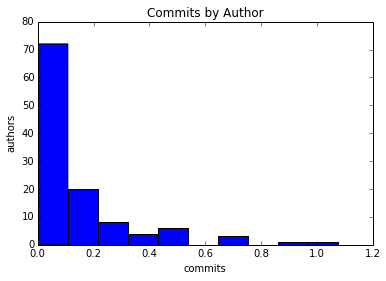

In [13]:
plt.figure()
#plt.figure(figsize=(15, 5))
plt.title('Commits by Author')
plt.xlabel('commits')
plt.ylabel('authors')
plt.hist([x[1] for x in norm_blame_by_commit])
print ''


In [14]:
import numpy as np
a = np.array([x[1] for x in norm_blame_by_commit])
lthresh = np.percentile(a,0.5)
uthresh = np.percentile(a,99.5) 
norm_blame_by_commit_f = [x for x in norm_blame_by_commit if x[1] >= lthresh and x[1] <= uthresh]

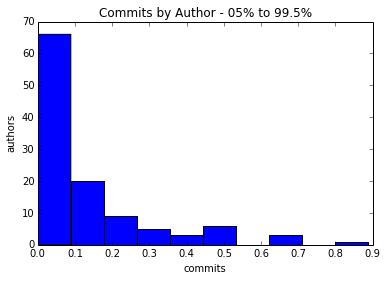

In [15]:
plt.figure()
#plt.figure(figsize=(15, 5))
plt.title('Commits by Author - 05% to 99.5%')
plt.xlabel('commits')
plt.ylabel('authors')
plt.hist([x[1] for x in norm_blame_by_commit_f])
print ''

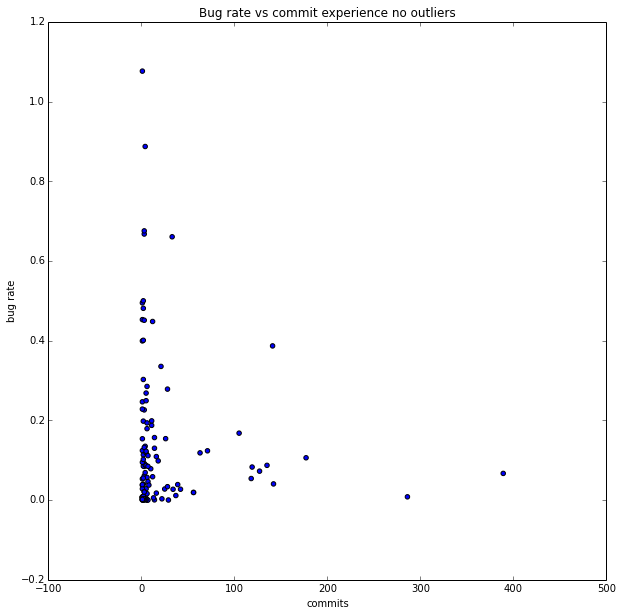

In [16]:
plt.figure(figsize=(10, 10))
plt.xlabel('commits')
plt.ylabel('bug rate')

plt.title('Bug rate vs commit experience no outliers')

#filter outliers
norm_blame_vs_commit_count_filtered = [zz for zz in norm_blame_vs_commit_count if zz[1] < 400 and zz[2] < 3]

N = 50
x = [zz[1] for zz in norm_blame_vs_commit_count_filtered]
y = [zz[2] for zz in norm_blame_vs_commit_count_filtered]

plt.scatter(x, y)
#plt.xlabel(’commits’)
plt.show()

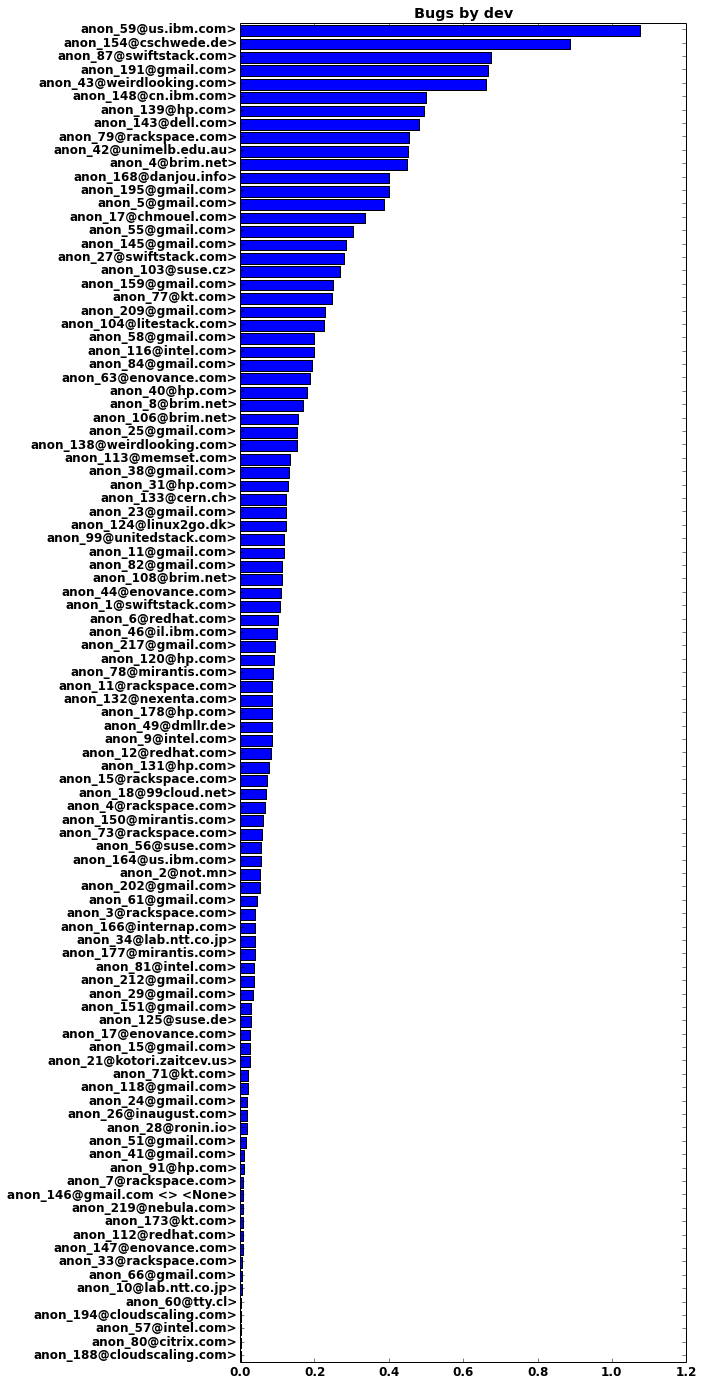

In [17]:
val = sorted(norm_blame_by_commit, key=lambda x:x[1], reverse=True)
plt.figure(figsize=(8, 24))
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

plt.title('Bugs by dev')
names = [x[0] for x in val][:100]
names.reverse()
bugs =  [x[1] for x in val][:100]
bugs.reverse()

# The X axis can just be numbered 0,1,2,3...
x = np.arange(len(names))

plt.barh(x, bugs)
plt.yticks(x + 0.5, names)
print ''

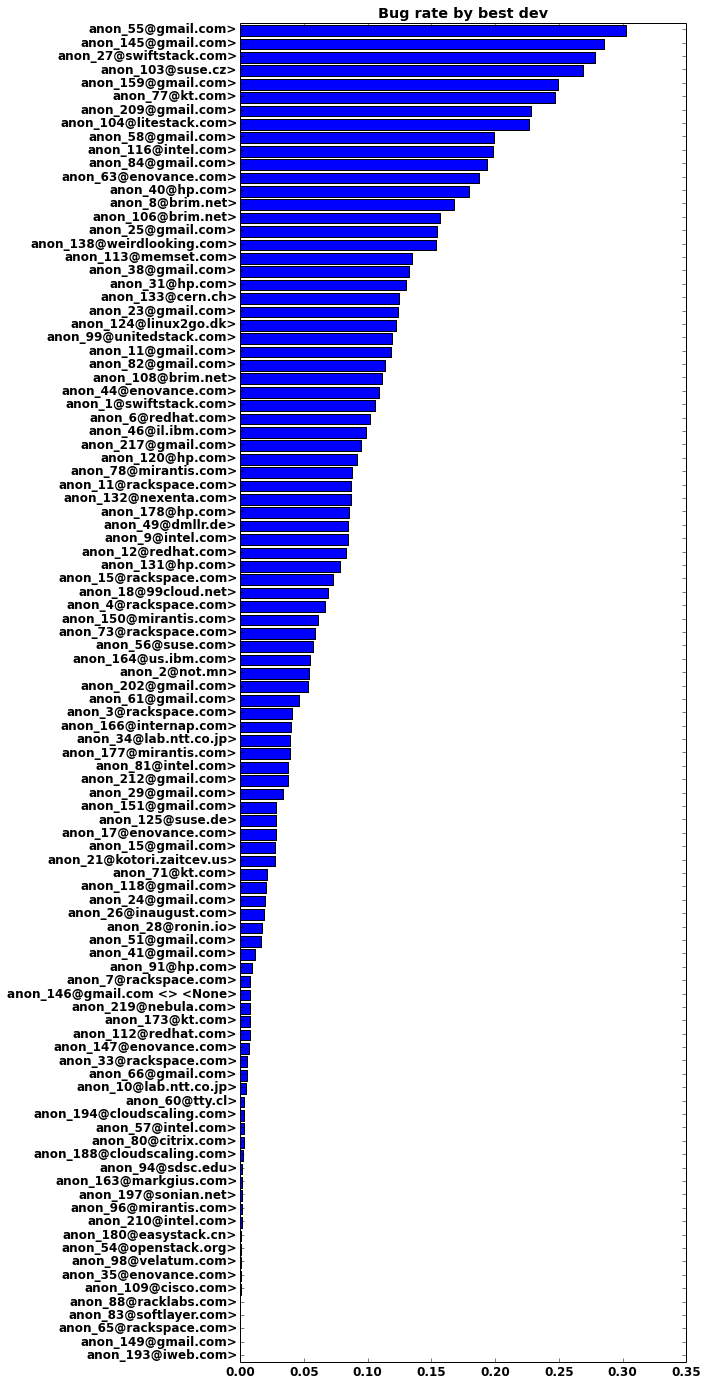

In [18]:
val = sorted(norm_blame_by_commit, key=lambda x:x[1], reverse=True)
plt.figure(figsize=(8, 24))
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

plt.title('Bug rate by best dev')
val.reverse()
names = [x[0] for x in val][:100]
bugs =  [x[1] for x in val][:100]

# The X axis can just be numbered 0,1,2,3...
x = np.arange(len(names))

plt.barh(x, bugs)
plt.yticks(x + 0.5, names)
print ''

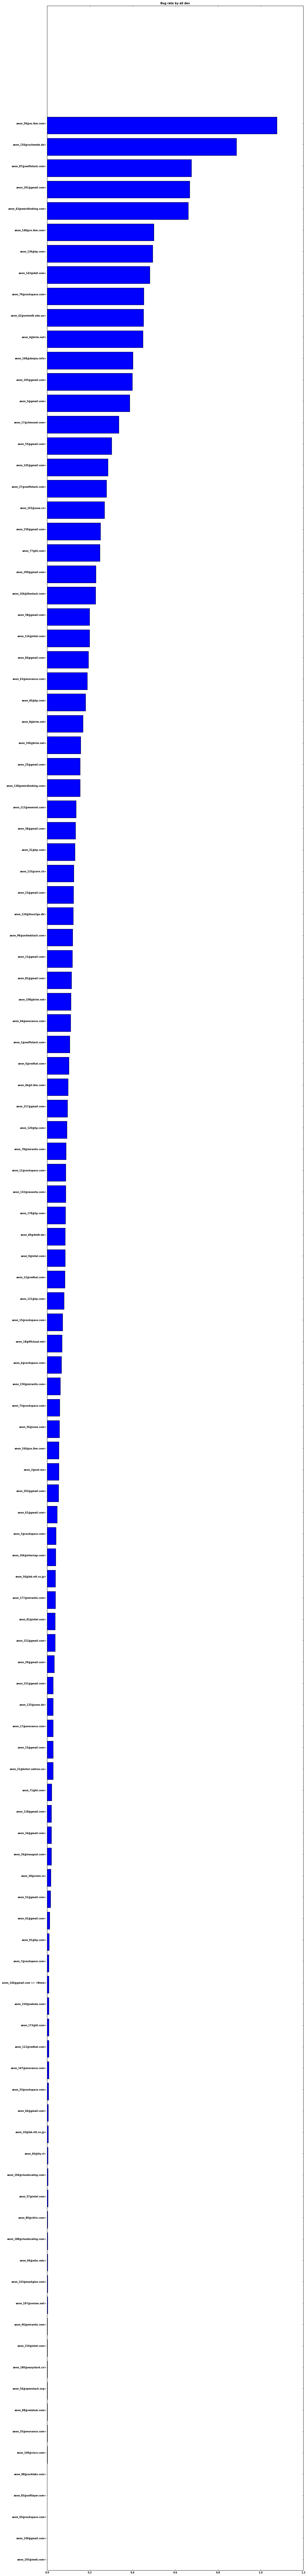

In [19]:
plt.figure(figsize=(16, 160))
font = {'size'   : 8}
matplotlib.rc('font', **font)

plt.title('Bug rate by all dev')
names = [x[0] for x in val]
bugs =  [x[1] for x in val]

# The X axis can just be numbered 0,1,2,3...
x = np.arange(len(names))

plt.barh(x, bugs)
plt.yticks(x + 0.50, names)
print ''

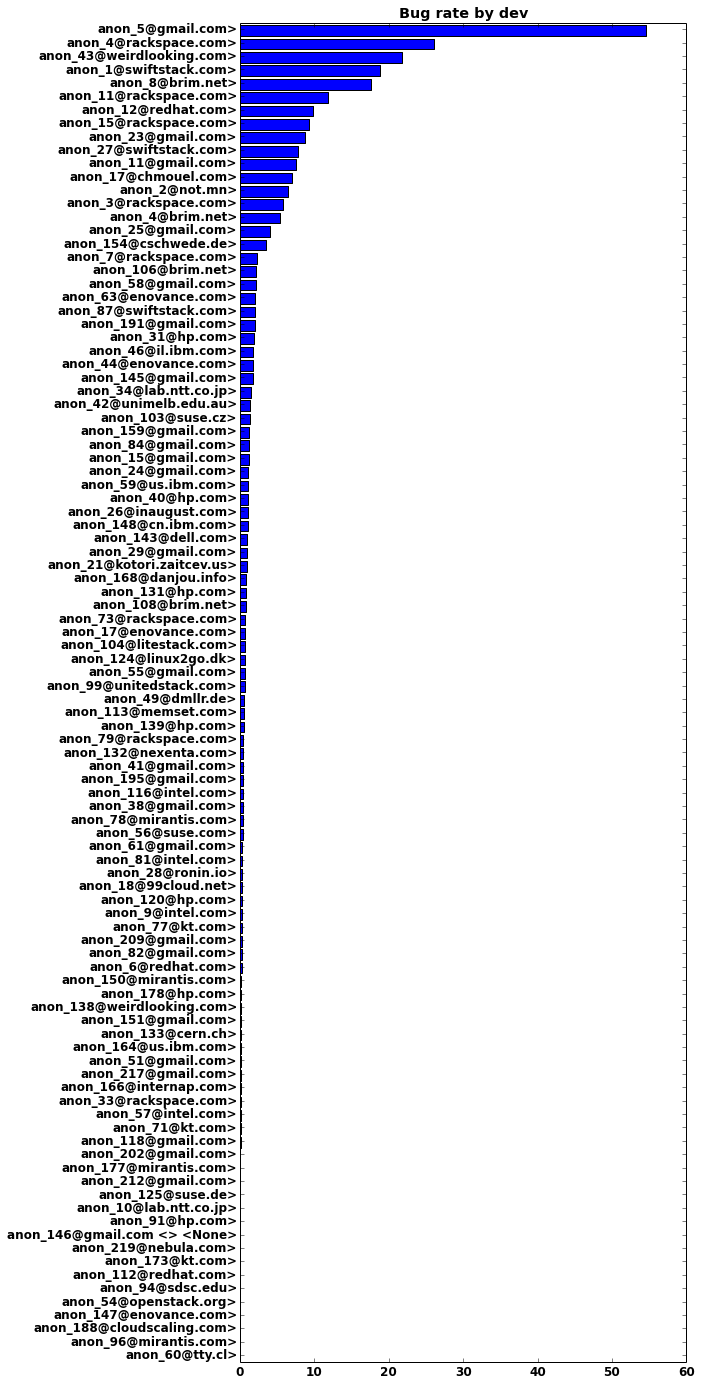

In [20]:
val = sorted(blame_by_commit.items(), key=lambda x:x[1], reverse=True)

plt.figure(figsize=(8, 24))
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)


plt.title('Bug rate by dev')
names = [x[0] for x in val][:100]
names.reverse()
bugs =  [x[1] for x in val][:100]
bugs.reverse()

# The X axis can just be numbered 0,1,2,3...
x = np.arange(len(names))

plt.barh(x, bugs)
plt.yticks(x + 0.5, names)
print ''